In [36]:
import math
import os
import gc
import re
import sys
import time
import json
import random
import datetime
import traceback
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

In [59]:
# train = pd.read_csv('../tmp/train/train.csv')
car_autohome_all = pd.read_csv('../tmp/train/car_autohome_all.csv')
line_k_param = pd.read_csv('../tmp/train/model_k_param.csv')
div_price_bn_data = pd.read_csv('../tmp/train/div_price_bn_data.csv')
div_price_bn_k_param = pd.read_csv('../tmp/train/div_price_bn_k_param.csv')
div_province = pd.read_csv('../tmp/train/div_province_data.csv')
div_province_k_param = pd.read_csv('../tmp/train/div_province_k_param.csv')
div_warehouse_data = pd.read_csv('../tmp/train/div_warehouse_data.csv')
div_warehouse_k_param = pd.read_csv('../tmp/train/div_warehouse_k_param.csv')
div_mile_k_param = pd.read_csv('../tmp/train/div_mile_k_param.csv')
# model_global_mean = pd.read_csv('../tmp/train/model_global_mean.csv')

In [60]:
div_mile_k_param.head()

,k,b
0,-0.181138,0.025038


In [65]:
list(range(0,20,2))

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

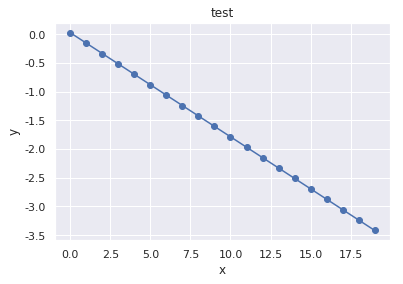

In [61]:
plt.figure()
plt.title(u'test')
plt.xlabel(u'x')
plt.ylabel(u'y')
plt.grid(True)
# x = list(div_warehouse_data.warehouse_year.values)
# y = list(div_warehouse_data.rate.values)
# plt.plot(x, y, 'k.')

k,b = div_mile_k_param.loc[0, ['k', 'b']]
x = range(0,20)
y = [k * i+b for i in range(0,20)]
plt.plot(x, y, 'o-')

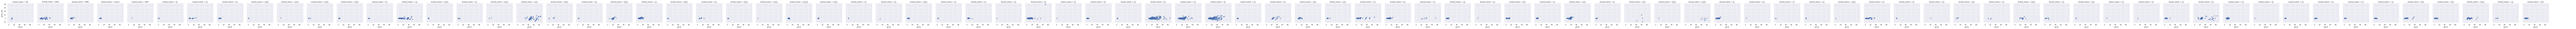

In [45]:
# data = div_province.loc[(div_province['province'] == '北京'), :].reset_index(drop=True)
g = sns.FacetGrid(div_warehouse_data, col="brand_name")
g.map(plt.scatter, "price", "price_div", alpha=.7)

# for i, ax in enumerate(g.axes.flat):
#     k = div_price_bn_k_param.loc[i, ['k']].values
#     x = range(0,100)
#     y = [j*k for j in range(0, 100)]
#     ax.plot(x, y, c=".2", ls="-")

g.add_legend()

In [ ]:
g = sns.FacetGrid(model, col="model_name")
g.map(plt.scatter, "used_years", "k", color="#338844", edgecolor="white", alpha=.7)

In [3]:
# 根据款型计算中位数
median_price = train.groupby(['brand_area', 'brand_slug', 'model_slug', 'model_detail_slug', 'online_year', 'price_bn'])['price'].median().reset_index().rename(columns={'price': 'median_price'})
median_price = median_price.sort_values(by=['brand_slug', 'model_slug', 'online_year', 'price_bn']).reset_index(drop=True)
median_price = median_price.loc[median_price.groupby(['brand_slug', 'model_slug', 'online_year']).price_bn.idxmin(), :]

median_price['used_years'] = datetime.datetime.now().year - median_price['online_year']
median_price.loc[(median_price['used_years'] < 0), 'used_years'] = 0
median_price['rate'] = median_price['median_price'] / median_price['price_bn']
median_price = median_price.loc[(median_price['rate'] < 1), :].reset_index(drop=True)

In [4]:
column = ['系列']
column.extend(['used_year_'+str(i) for i in range(0,21)])
brand_area = list(set(hedge.brand_area.values))
data = pd.DataFrame([], columns=column)
for brand_area in list(set(hedge.brand_area.values)):
    temp = hedge.loc[(hedge['brand_area'] == brand_area), :].reset_index(drop=True)
    area = [brand_area]
    area.extend(list(temp.hedge.values))
    data = data.append(pd.DataFrame([area], columns=column))
data

,系列,used_year_0,used_year_1,used_year_2,used_year_3,used_year_4,used_year_5,used_year_6,used_year_7,used_year_8,...,used_year_11,used_year_12,used_year_13,used_year_14,used_year_15,used_year_16,used_year_17,used_year_18,used_year_19,used_year_20
0,韩系,0.812039,0.720721,0.666466,0.615425,0.497427,0.479846,0.431402,0.419089,0.335100,...,0.244989,0.196019,0.139147,0.157835,0.140407,0.124904,0.111113,0.098845,0.087931,0.078222
0,日系,0.869336,0.812744,0.763964,0.703637,0.624687,0.557907,0.472103,0.394144,0.349153,...,0.234192,0.250417,0.181631,0.164521,0.157937,0.112138,0.098665,0.086811,0.076381,0.067204
0,国产,0.829855,0.724943,0.656094,0.581219,0.503230,0.443864,0.387755,0.315638,0.265625,...,0.159605,0.175879,0.172130,0.152513,0.135132,0.119731,0.106086,0.093996,0.083284,0.073792
0,美系,0.787890,0.750208,0.629183,0.604977,0.535905,0.482973,0.418246,0.367181,0.294974,...,0.187735,0.167950,0.123547,0.161961,0.144656,0.129200,0.115395,0.103065,0.092052,0.082217
0,法系,0.812039,0.720618,0.661855,0.541260,0.523691,0.445332,0.365736,0.342973,0.278259,...,0.177727,0.140811,0.177425,0.157835,0.140407,0.124904,0.111113,0.098845,0.087931,0.078222
0,欧系,0.729927,0.681985,0.626102,0.537236,0.496293,0.434642,0.376433,0.323144,0.275469,...,0.184396,0.167095,0.193823,0.175028,0.158055,0.142729,0.128888,0.116390,0.105103,0.094911
0,德系,0.812039,0.764748,0.707420,0.647252,0.568955,0.525114,0.442708,0.387097,0.337209,...,0.206592,0.219302,0.164009,0.128662,0.140407,0.124904,0.111113,0.098845,0.087931,0.078222


展示系列: 韩系
展示系列: 日系
展示系列: 国产
展示系列: 美系
展示系列: 法系
展示系列: 欧系
展示系列: 德系


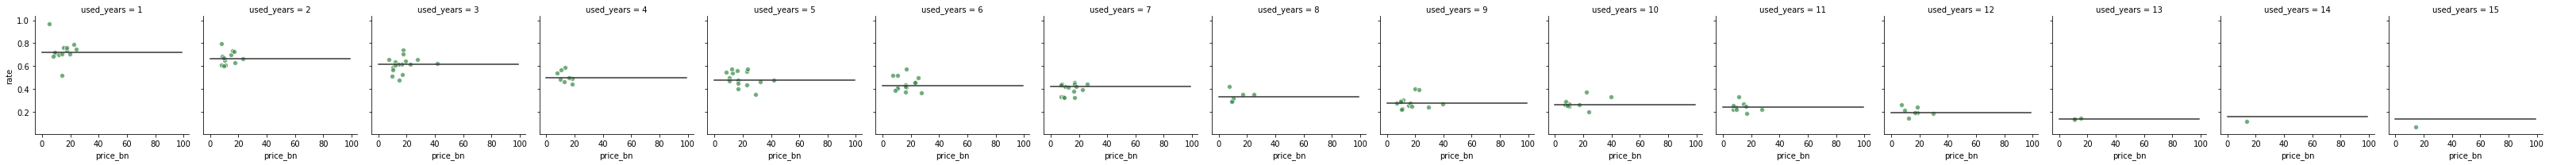

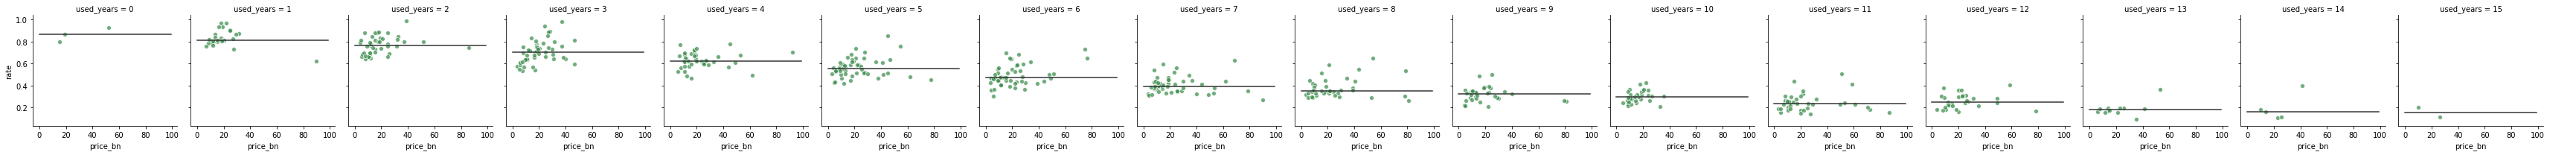

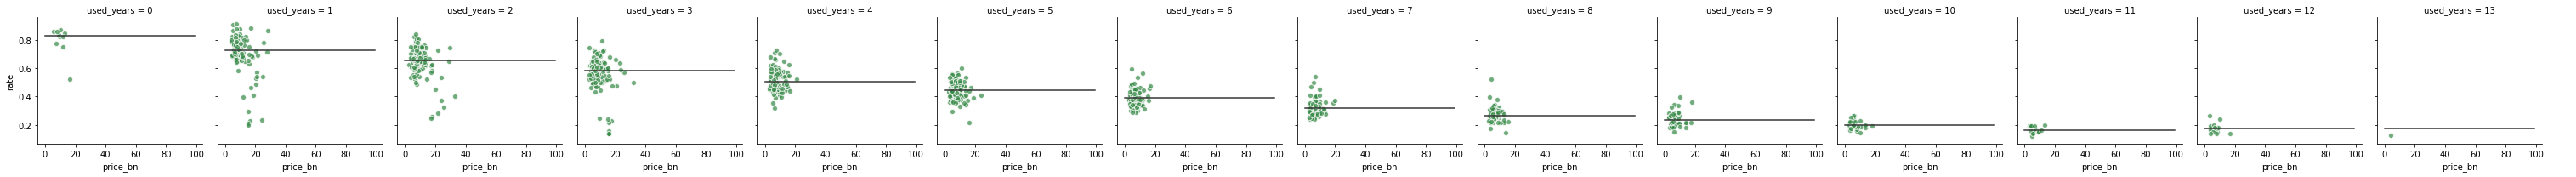

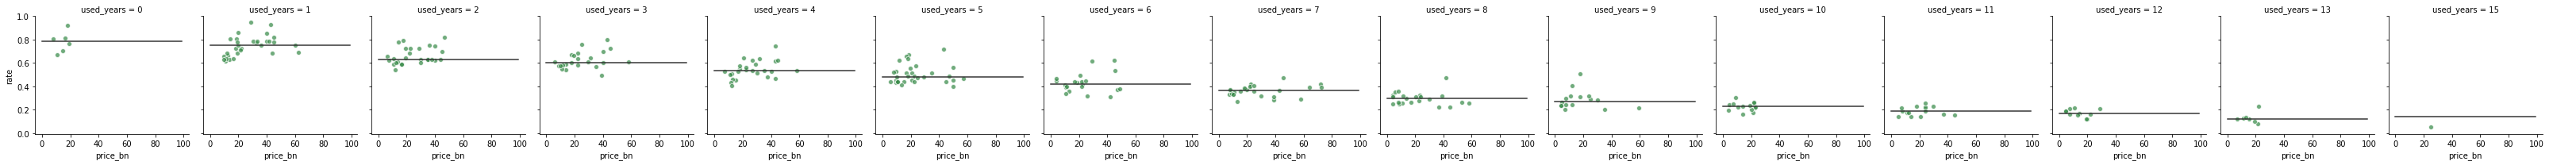

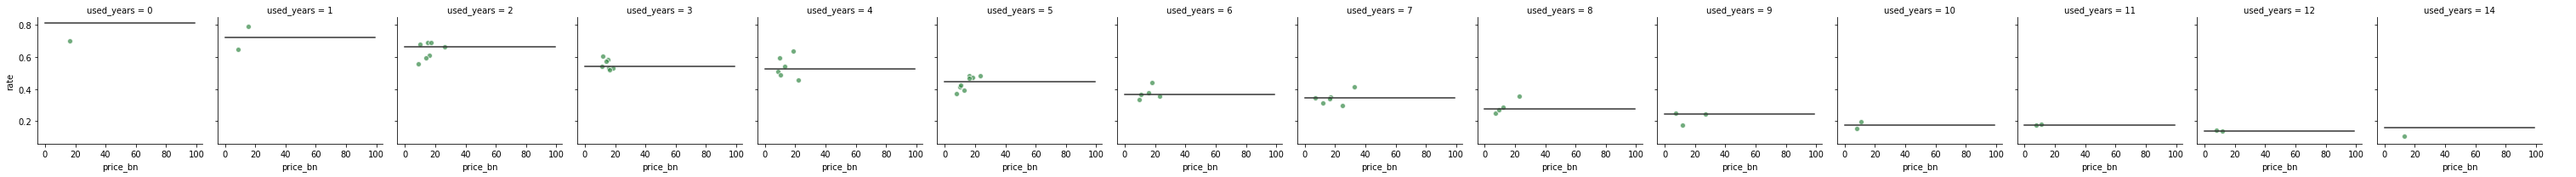

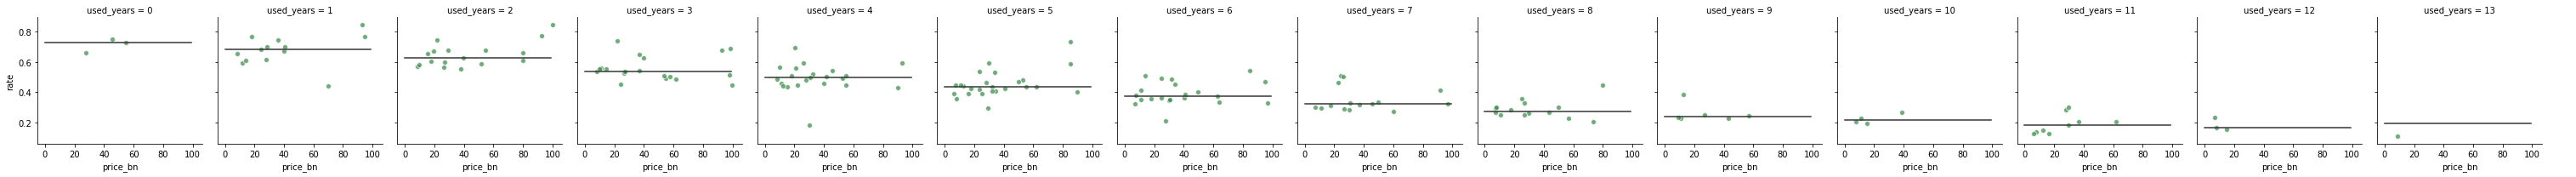

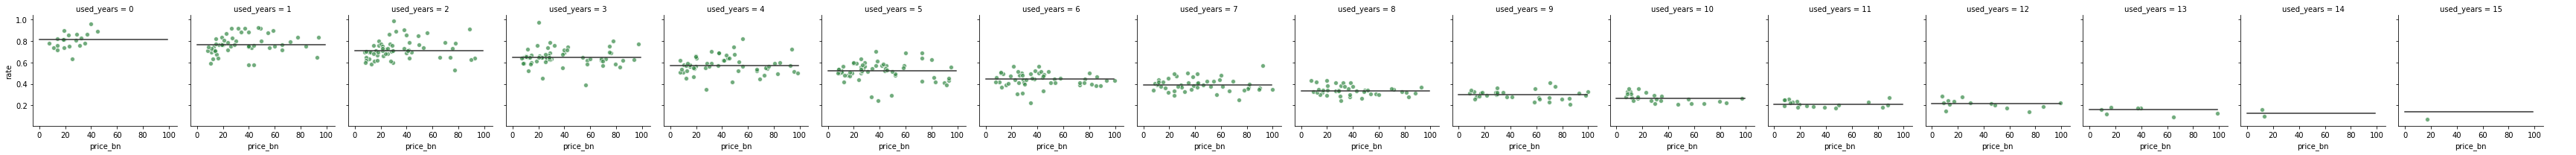

In [5]:
for brand_area in list(set(hedge.brand_area.values)):
    print('展示系列:', brand_area)
    temp = 0
    data = median_price.loc[(median_price['brand_area'] == brand_area)&(median_price['price_bn'] < 100), :].reset_index(drop=True)

    g = sns.FacetGrid(data, col="used_years")
    g.map(plt.scatter, "price_bn", "rate", color="#338844", edgecolor="white", alpha=.7)
#     for i, ax in enumerate(g.axes.flat):
#         print(i)
#         if len(median_price.loc[(median_price['brand_area'] == brand_area)&(median_price['used_years'] == i), :]) <=1:
#             temp= temp + 1
#         k = line_k_param.loc[(line_k_param['brand_area'] == brand_area)&(line_k_param['used_years'] == (i+temp)), ['k']].values[0]
#         x = range(0,100)
#         y = [k if k <= 1 else 1 for i in range(0, 100)]
#         y = [i if i >= 0 else 0 for i in y]
#         ax.plot(x, y, c=".2", ls="--")

    for i, ax in enumerate(g.axes.flat):
        if len(median_price.loc[(median_price['brand_area'] == brand_area)&(median_price['used_years'] == i), :]) < 1:
            temp= temp + 1
        b = hedge.loc[(hedge['brand_area'] == brand_area)&(hedge['used_years'] == i+temp), ['hedge']].values[0]
        x = range(0,100)
        y = [b for i in range(0, 100)]
        ax.plot(x, y, c=".2", ls="-")

    g.add_legend()

In [10]:
column = ['系列']
column.extend(['used_year_'+str(i) for i in range(0,21)])
brand_area = list(set(div_price_bn.brand_area.values))
data = pd.DataFrame([], columns=column)
for brand_area in list(set(div_price_bn.brand_area.values)):
    temp = div_price_bn.loc[(div_price_bn['brand_area'] == brand_area), :].reset_index(drop=True)
    area = [brand_area]
    area.extend(list(temp.hedge.values))
    data = data.append(pd.DataFrame([area], columns=column))
data

,系列,used_year_0,used_year_1,used_year_2,used_year_3,used_year_4,used_year_5,used_year_6,used_year_7,used_year_8,...,used_year_11,used_year_12,used_year_13,used_year_14,used_year_15,used_year_16,used_year_17,used_year_18,used_year_19,used_year_20
0,韩系,0.732221,0.719434,0.555136,0.406294,0.642302,0.287325,0.324078,0.151973,0.265867,...,0.075296,0.080405,0.091222,0.048428,0.039888,0.032854,0.027061,0.022289,0.018358,0.015121
0,日系,0.537676,0.793328,0.568857,0.551421,0.584650,0.384120,0.350898,0.258287,0.159183,...,0.148073,0.122463,-0.029336,0.080948,0.032773,0.026486,0.021405,0.017298,0.013980,0.011298
0,国产,0.792734,0.556434,0.527665,0.378567,0.288543,0.222733,0.167729,0.109299,0.151555,...,0.080358,-0.015150,0.051034,0.041326,0.033465,0.027099,0.021944,0.017770,0.014389,0.011652
0,美系,0.728652,0.555899,0.589511,0.494037,0.370344,0.286580,0.249518,0.281116,0.170704,...,0.112315,0.118911,0.057455,0.048872,0.040294,0.033221,0.027390,0.022583,0.018619,0.015351
0,法系,0.732221,0.443880,0.610157,0.581103,0.194305,0.182150,0.278007,0.307296,0.080277,...,0.051986,0.071385,0.058796,0.048428,0.039888,0.032854,0.027061,0.022289,0.018358,0.015121
0,欧系,0.732221,0.271739,0.409868,0.365602,0.349427,0.271994,0.086872,0.069040,0.109767,...,-0.056130,-0.010127,0.020755,0.048428,0.039888,0.032854,0.027061,0.022289,0.018358,0.015121
0,德系,0.735789,0.413109,0.489360,0.173076,0.284632,0.243210,0.161450,0.119406,0.108923,...,0.031148,0.028396,0.039895,0.047988,0.039486,0.032490,0.026734,0.021998,0.018101,0.014894


In [15]:
model_detail_slug = '110158_autotis'
province = '四川'
warehouse = 1
mile = 2 / 12

median_price = model_global_mean.loc[(model_global_mean['model_detail_slug'] == model_detail_slug), 'predict_price'].values[0]
print('median_price', median_price)

province_price = div_province.loc[(div_province['province'] == province), 'price_div'].values[0] 
print('province_price', province_price)

k = div_warehouse.loc[0, ['k']].values[0]
warehouse_price = k * warehouse
print('warehouse_price', warehouse_price)

k, b = div_mile.loc[0, ['k', 'b']].values
mile_price = k * mile + b
print('mile_price', mile_price)

final_price = median_price + province_price + warehouse_price + mile_price
print('final_price', final_price)

median_price 9.658
province_price 0.0
warehouse_price 0.06856609806397602
mile_price -0.004627078536066885
final_price 9.721939019527907
